<a href="https://colab.research.google.com/github/deanhadzi/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a linear regression model with multiple features.
- [x] Get mean absolute error for the test set.
- [x] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Importing additional libs

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import category_encoders as ce 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [5]:
# Generate initial report using Pandas profiling.

df.profile_report()

In [0]:
# Dropping the EASE-MENT since it's full with NaNs

df.drop(labels='EASE-MENT', axis=1, inplace=True)

In [7]:
# Changing the SALE_DATE to datetime format and checking the first and last date within the feature.

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                   23040
unique                    120
top       2019-01-24 00:00:00
freq                      480
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [8]:
# Creating the train and test dataframes, based on the assignement instructions.
# Cut off date is 04/01/19

cutoff = pd.to_datetime('2019-04-01')
train = df[df['SALE_DATE'] < cutoff]
test = df[df['SALE_DATE'] >= cutoff]
train.shape, test.shape

((18167, 20), (4873, 20))

In [9]:
# After the date split, I want to check what's the shape of the dataframes 
# when we implement the new set of assignement guidelines 

train.loc[(train['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') 
          & (train['SALE_PRICE'] >= 100000)
          & (train['SALE_PRICE'] <= 2000000)].shape    

(2517, 20)

In [10]:
test.loc[(test['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') 
          & (test['SALE_PRICE'] >= 100000)
          & (test['SALE_PRICE'] <= 2000000)].shape

(647, 20)

In [12]:
# Running the final split of the dataframes. Since I was getting the error below,
# I decided to go back to check the shapes, just to make sure that no data is getting lost.

building_category = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')
sell_price = (df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)
mask = building_category & sell_price

train = train[mask]
test = test[mask]
train.shape, test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



((2517, 20), (647, 20))

In [0]:
# Doing the data exploration by using seaborn.
# First the correlation matrix of the train data subset.

corr = train.corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

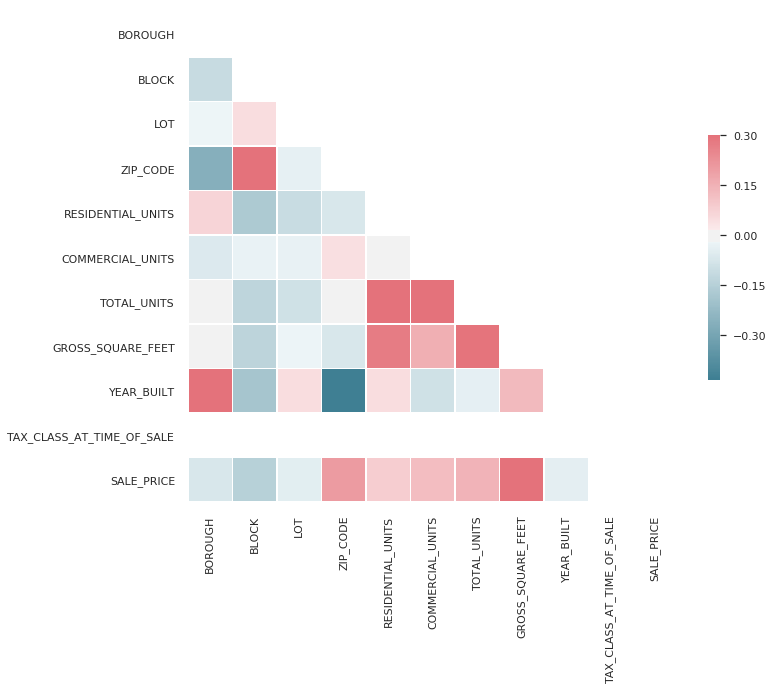

In [14]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

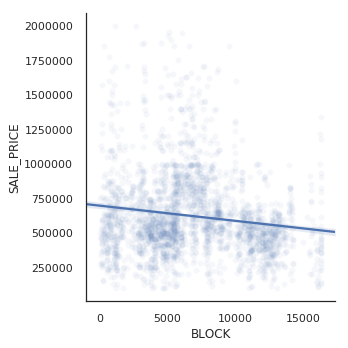

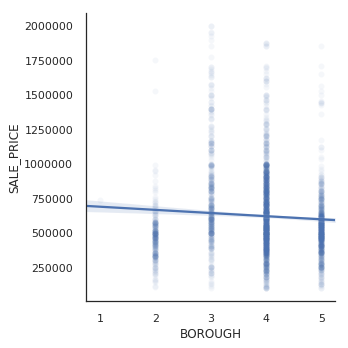

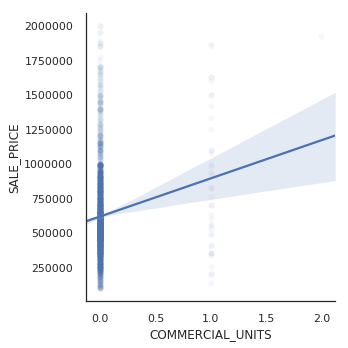

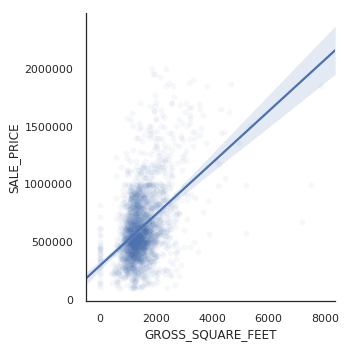

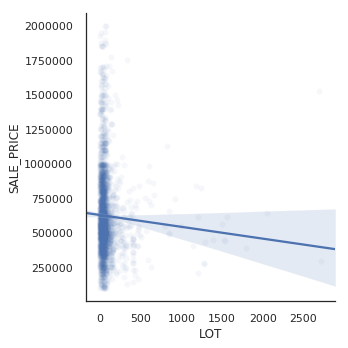

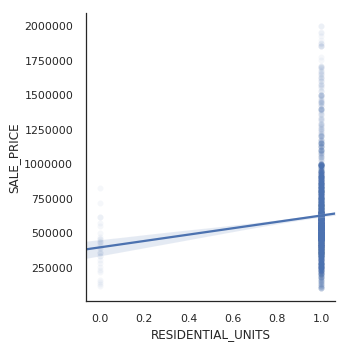

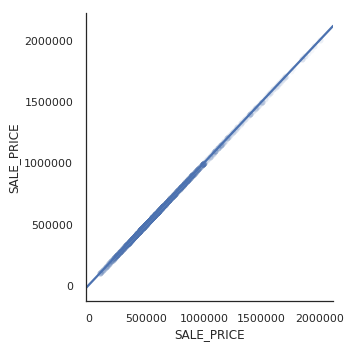

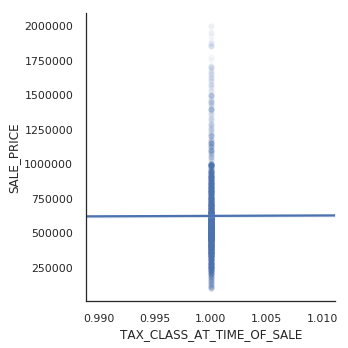

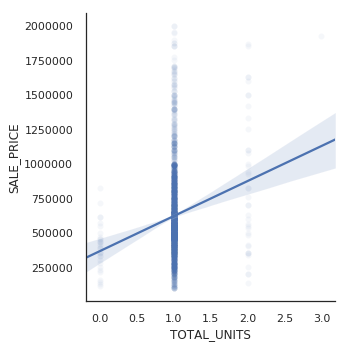

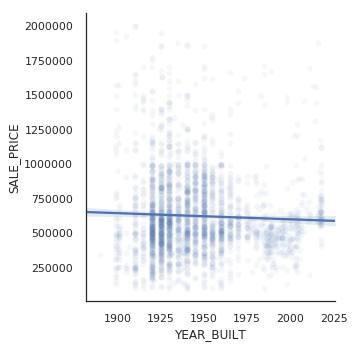

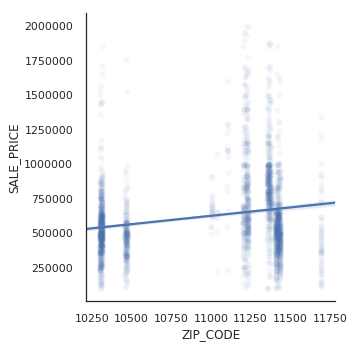

In [15]:
# Secondly checking the numerical features against the price.
# Values seem all over the place. 

numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

In [16]:
train.describe(exclude='number').T.sort_values(by='unique')

count  ...                 last
BUILDING_CLASS_CATEGORY         2517  ...                  NaN
APARTMENT_NUMBER                   1  ...                  NaN
TAX_CLASS_AT_PRESENT            2517  ...                  NaN
BUILDING_CLASS_AT_TIME_OF_SALE  2517  ...                  NaN
BUILDING_CLASS_AT_PRESENT       2517  ...                  NaN
SALE_DATE                       2517  ...  2019-03-30 00:00:00
NEIGHBORHOOD                    2517  ...                  NaN
LAND_SQUARE_FEET                2517  ...                  NaN
ADDRESS                         2517  ...                  NaN

[9 rows x 6 columns]

In [0]:
# Selecting the numeric columns and dropping the missing values. 

train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)

X_train = train_subset[features]
y_train = train_subset[target]

X_test = test_subset[features]
y_test = test_subset[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2517, 10), (2517,), (647, 10), (647,))

In [0]:
# Before we do the one hot encoding we only have 10 numeric features
# to begin with, so we'll use all of them. 

selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



((2517, 10), (647, 10))

In [0]:
# Finally calculating the MAE of the test subset.

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $169,951
